In [20]:
import os
import glob
import pickle
import datetime
import numpy as np
from tqdm.notebook import tqdm_notebook, trange
from astropy.io import fits
from photutils import DAOStarFinder, CircularAperture
import photutils.psf
import matplotlib.pyplot as plt
from astropy.visualization import LogStretch, AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy.signal import peak_widths
import astropy.units as u
import pandas as pd
from scipy import stats
from calibFuncs import *
from circlesym import *

In [2]:
datadir = 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\William\\trapezium_data\\visao_astro'

In [3]:
uniques, VisAO_science, VisAO_darks = sortData(datadir, instrument='VisAO', filesdeep='*\\*\\', returntab=True)

  0%|                                                                              | 44/33363 [00:00<01:17, 431.38it/s]

sorting individual images


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 118.89it/s]

sorting unique datasets into lists


In [4]:
# data takes a long time to sort so pickle result
filename = 'visao_science.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_science,outfile)
outfile.close()

filename = 'visao_uniques.pkl'
outfile = open(filename,'wb')
pickle.dump(uniques,outfile)
outfile.close()

filename = 'visao_darks.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_darks,outfile)
outfile.close()

In [5]:
# read in pickle
infile = open('visao_science.pkl','rb')
VisAO_science = pickle.load(infile)
infile.close()

infile = open('visao_uniques.pkl','rb')
uniques = pickle.load(infile)
infile.close()

infile = open('visao_darks.pkl','rb')
VisAO_darks = pickle.load(infile)
infile.close()

In [6]:
# sorts dark fields into a subfolder in their directory named dark
VisAO_new_darks = []
for i in range(len(VisAO_darks)):
    dataset = VisAO_darks[i]
    new_darkset = []
    for dark_im in dataset:
        imname = dark_im.split('\\')[-1]
        newroot = dark_im.replace(dark_im.split('\\')[-1], 'dark\\')
        if os.path.exists(newroot):
            pass
        else:
            os.mkdir(newroot)
        newpath = newroot+imname
        try:
            os.rename(dark_im, newpath)
        except FileNotFoundError:
            pass
        new_darkset.append(newpath)
    VisAO_new_darks.append(new_darkset)

filename = 'visao_new_darks.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_new_darks,outfile)
outfile.close()

In [7]:
# introduce median combine function
def mediancombine(filelist, norm=False):
    '''
    median combine frames, can norm for flats or not
    '''
    # gather some information about the images
    n = len(filelist)
    first_frame_data = fits.getdata(filelist[0])
    imsize_y, imsize_x = first_frame_data.shape
    # construct an empty cube with proper dimensions
    fits_stack = np.zeros((imsize_y, imsize_x, n))
    # fill cube with images in filelist
    for ii in range(0, n):
        im = fits.getdata(filelist[ii])
        if norm is True:
            im /= np.nanmedian(im)
        fits_stack[:, :, ii] = im
    # take the median combination of the images along the
    # correct axis (we made this the 3rd axis of our image cube)
    med_frame = np.nanmedian(fits_stack, axis=2)
    return med_frame

In [8]:
# sorts science images into a subfolder in their directory named science
VisAO_new_science = []
for i in trange(len(VisAO_science)):
    dataset = VisAO_science[i]
    exptimes = []
    # print('checking exp times')
    for im in tqdm_notebook(dataset):
        try:
            im_expt = fits.getheader(im)['EXPTIME']
            if im_expt not in exptimes:
                exptimes.append(im_expt)
        except FileNotFoundError:
            pass
                
    for expt in tqdm_notebook(exptimes):
        ims_with_expt = []
        ims_with_expt_new_path = []
        for im in dataset:
            try:
                im_expt = fits.getheader(im)['EXPTIME']
                if im_expt == expt:
                    ims_with_expt.append(im)
            except FileNotFoundError:
                pass
            

        for sci_im in tqdm_notebook(ims_with_expt):
            imname = sci_im.split('\\')[-1]
            newroot = sci_im.replace(sci_im.split('\\')[-1], 'science'+str(round(expt, 5))+'s\\')
            if os.path.exists(newroot):
                # print('folder ', newroot, 'exists')
                pass
            else:
                # print('creating folder ', newroot)
                os.mkdir(newroot)
            newpath = newroot+imname
            try:
                os.rename(sci_im, newpath)
            except FileNotFoundError:
                pass
            ims_with_expt_new_path.append(newpath)
        VisAO_new_science.append(ims_with_expt_new_path)

filename = 'visao_new_science.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_new_science,outfile)
outfile.close()

In [9]:
infile = open('visao_new_science.pkl','rb')
VisAO_new_science = pickle.load(infile)
infile.close()

infile = open('visao_new_darks.pkl','rb')
VisAO_new_darks = pickle.load(infile)
infile.close()

In [10]:
nights = glob.glob(datadir+'\\**\\')#, recursive=True)
obs = []
for night in nights:
    runs = glob.glob(night+'\\**\\')
    for run in runs:
        obs.append(run)

darks = []
obs2 = []
for ob in obs:
    exptsets = glob.glob(ob+'science*\\*fits*')
    if len(exptsets) != 0:
        obs2.append(exptsets)
        darkset = glob.glob(ob+'dark*\\*fits*')
        darks.append(darkset)

In [11]:
# write master dark for each observation
master_darks = []
master_dark_paths = []
for obs in tqdm_notebook(darks):
    darkim = obs[0]
    oldheader = fits.getheader(darkim)
    oldroot = darkim.replace('dark\\'+darkim.split('\\')[-1], '\\')
    newpath = oldroot+'MasterDark'+str(oldheader['EXPTIME'])+'s'+str(oldheader['V47GAIN'])+'.fit'
    master_dark_paths.append(newpath)
    master_dark = mediancombine(obs)
    master_darks.append(master_dark)
    fits.writeto(newpath, master_dark, oldheader, overwrite=True)

In [12]:
# fix 2015 baades window imgs
windows = []
for dataset in obs2:
    if 'baade' in dataset[0]:
        windows.append(dataset)

baades_corrected = []
for dataset in windows[0:1]:
    first_frame, first_header = fits.getdata(dataset[0], header=True)
#     imgandhist(first_frame)
    # 1010:1025 -> 512:526
    # 0:15 - > 498:512
    n = len(dataset)
    imsize_y, imsize_x = first_frame.shape
    empty_img = np.zeros((n, imsize_y, imsize_x))
    for ii in trange(0, n):
        im = fits.getdata(dataset[ii])
        if ii < 8:
            empty_img[ii, 497:512, :] = im[0:15, :]
    #         imgandhist(empty_img[ii], log=True)
            empty_img[ii, 512:526, :] = im[1010:1025, :]
    #         imgandhist(empty_img[ii], log=True)
            empty_img[ii, 0:497, :] = im[15:512]
    #         imgandhist(empty_img[ii], log=True)
            empty_img[ii, 526:, :] = im[512:1010, :]
    #         imgandhist(empty_img[ii], log=True)
        else:
            empty_img[ii, :, :] = im
    baades_corrected.append(empty_img)
   

In [13]:
import numpy.fft as fft
import scipy.interpolate as sinterp

def high_pass_filter(img, filtersize=10):
    """
    A FFT implmentation of high pass filter.

    Args:
        img: a 2D image
        filtersize: size in Fourier space of the size of the space. In image space, size=img_size/filtersize

    Returns:
        filtered: the filtered image
    """
    # mask NaNs if there are any
    nan_index = np.where(np.isnan(img))
    if np.size(nan_index) > 0:
        good_index = np.where(~np.isnan(img))
        y, x = np.indices(img.shape)
        good_coords = np.array([x[good_index], y[good_index]]).T # shape of Npix, ndimage
        nan_fixer = sinterp.NearestNDInterpolator(good_coords, img[good_index])
        fixed_dat = nan_fixer(x[nan_index], y[nan_index])
        img[nan_index] = fixed_dat

    transform = fft.fft2(img)

    # coordinate system in FFT image
    u,v = np.meshgrid(fft.fftfreq(transform.shape[1]), fft.fftfreq(transform.shape[0]))
    # scale u,v so it has units of pixels in FFT space
    rho = np.sqrt((u*transform.shape[1])**2 + (v*transform.shape[0])**2)
    # scale rho up so that it has units of pixels in FFT space
    # rho *= transform.shape[0]
    # create the filter
    filt = 1. - np.exp(-(rho**2/filtersize**2))

    filtered = np.real(fft.ifft2(transform*filt))

    # restore NaNs
    filtered[nan_index] = np.nan
    img[nan_index] = np.nan

    return filtered

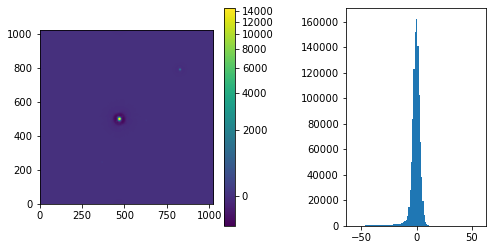

In [29]:
# size=img_size/filtersize
# filtersize = img_size/size

test = high_pass_filter(baades_corrected[0][0], filtersize=baades_corrected[0][0].shape[0]/100)


def imgandhist(img, log=False):
    from astropy.stats import sigma_clip
    fig = plt.figure(figsize=(8,4))
    ax1 = plt.subplot2grid((3,6), (0,0), rowspan=3, colspan=3)
    im_frame = ax1.imshow(img, norm=ImageNormalize(stretch=AsinhStretch()), origin='lower')
    plt.colorbar(im_frame, ax=ax1)
    ax2 = plt.subplot2grid((3,6), (0,4), rowspan=3, colspan=2)
    ax2.hist(sigma_clip(img.flatten(), sigma=10), bins=100)
    if log:
        ax2.set_xscale('log')
    #plt.show()
    
imgandhist(test)

In [14]:
# dark subtract and save as cube
for i in trange(len(obs2)):
    sci_ims = obs2[i]
    dark_ims = darks[i]
    dark = master_darks[i]
    firstim = sci_ims[0]
    try:        
        first_frame_data, firstheader = fits.getdata(firstim, header=True)
        date = firstheader['DATE-OBS'].split('T')[0]
        targ = firstheader['OBJECT']
        expt = firstheader['EXPTIME']
        newroot = firstim.replace('\\science'+str(round(expt, 5))+'s\\'+firstim.split('\\')[-1], '\\')
        newpath = newroot+targ+'_'+date+'_'+'darksub_cube.fit'

        n = len(sci_ims)

        if 'baade' in sci_ims[0]:
            if 'baade_zp_' not in dataset[0]:
                fits_stack = baades_corrected[0]
                n = len(fits_stack)
                for ii in range(0, n):
                    fits_stack[ii, :, :] -= dark
        else:        
            imsize_y, imsize_x = first_frame_data.shape
            fits_stack = np.zeros((n, imsize_y, imsize_x))
            for ii in range(0, n):
                im = fits.getdata(sci_ims[ii])
                fits_stack[ii, :, :] = im - dark

        # delete raw data to save space
        for im in sci_ims:
            os.remove(im)
        for dark in dark_ims:
            os.remove(dark)

        fits.writeto(newpath, fits_stack, firstheader, overwrite=True)
    except FileNotFoundError:
        pass

In [1]:
from calibFuncs import *
from circlesym import *


# read in dark subtracted images
datadir = 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\William\\trapezium_data\\visao_astro'
darksubs = glob.glob(datadir+'\\**\\*darksub_cube.fit', recursive=True)

def imgandhist(img, log=False):
    from astropy.stats import sigma_clip
    fig = plt.figure(figsize=(8,4))
    ax1 = plt.subplot2grid((3,6), (0,0), rowspan=3, colspan=3)
    im_frame = ax1.imshow(img, norm=ImageNormalize(stretch=LogStretch()), origin='lower')
    plt.colorbar(im_frame, ax=ax1)
    ax2 = plt.subplot2grid((3,6), (0,4), rowspan=3, colspan=2)
    ax2.hist(sigma_clip(img.flatten(), sigma=10), bins=100)
    if log:
        ax2.set_xscale('log')
    #plt.show()

In [9]:
# baades 2015 darksubs[9:12]
# theba b broadband 2016 darksubs[14:17]
# theta b broadband 2018 darksubs[27, 29]

['C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\\William\\trapezium_data\\visao_astro\\visao_20161116_17\\tet1OriB_ip_350modes_20161117073420226445\\Theta1_Ori_C_2016-11-17_darksub_cube.fit',
 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\\William\\trapezium_data\\visao_astro\\visao_20161116_17\\tet1OriB_zp_350modes_20161117072924185566\\Theta1_Ori_C_2016-11-17_darksub_cube.fit',
 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\\William\\trapezium_data\\visao_astro\\visao_20161116_17\\tet1OriB_zp_350modes_20161117073136006316\\Theta1_Ori_C_2016-11-17_darksub_cube.fit']

In [ ]:
for path in tqdm_notebook(darksubs[9:12]):
    print('current darksubs ind is '+str(darksubs.index(path)))
    # read in darksub cube
    hdr = fits.getheader(path)
    data = fits.getdata(path)
    datadir = path.replace(path.split('\\')[-1], '')
    filname = path.split('\\')[-1]

    # list to store images needed to handle Woll-on images
    # if beamsplitter is on, split images into separate frames, add to images list
    # else, put image in images list
    if hdr['VWOLLSTN'] == 'IN':
        if data.shape[1] >= 1024:
            ha = data[:, 513:, :]
            ha_off = data[:, 0:512, :]
            images = [ha, ha_off]
            j = 0 # this is to save ha/off as different files later in the loop
    else:
        images = [data]
        
    # register images
    for image in images:
        # create guess, boxsize for center of image for registration
        imgandhist(image[0], log=True)
        skip = input('type \'skip\' to skip, else type \'go\': ')
        if skip != 'skip':
            try:
                cenx, ceny, fwhm = findFirst('blah', thresh=100, fwhmguess=5, bright=5, roundness=1, data=image[0])
            except TypeError:
                cenx, ceny, fwhm = (image.shape[1]//2, image.shape[2]//2, 3)
            print(cenx, ceny)
            boxsize = int(input('give boxsize: '))
            n = len(image)
            # coarse registration
#             coarse = np.zeros((n, image.shape[1], image.shape[2]))
#             for i in trange(n):
#                 frame = image[i]
#                 xsh, ysh = centroid(frame, cenx, ceny, nhalf=500, derivshift=1.)
#                 xsh -= image.shape[1]/2
#                 ysh -= image.shape[2]/2
#                 coarse[i, :, :] = shift_image(frame, xsh, ysh)

            coarse = crosscube(image, cenx, ceny, box=boxsize, returnmed=False, returncube=True)
            fits.writeto('test2.fit', coarse, fits.getheader(path), overwrite=True)
            
            imgandhist(np.nanmedian(coarse, axis=0), log=True)

            # fine registration
            fine = circlesym(datadir, filname, 'circlesym.fit', data=coarse, box=boxsize, center = [cenx, ceny], center_only=boxsize, save=False)
            hdr = fits.getheader(path)
            hdr.append(('COMMENT', 'aligned with crosscorrelation and center of circular symmetry'), end=True)

            # subdivide observation
            n = len(fine)
            start = 0
            if 9999 > n > 100:
                sections = n // int(str(n)[0])
                stop = sections
            elif n > 1e4:
                sections = n // 5
                stop = sections
            print('subdiv into sections len: '+str(sections))
            subdiv_stack = np.zeros((n, fine.shape[1], fine.shape[2]))
            for i in range(n // sections):
                subdiv = fine[start:stop]
                subdiv_stack[i, :, :] = np.nanmedian(subdiv, axis=0)
                if len(images) > 1:
                    if j == 0:
                        newpath = datadir+filname.replace('.fit', 'HA_subdivtest'+str(i)+'.fit')
                    else:
                        newpath = datadir+filname.replace('.fit', 'HAoff_subdivtest'+str(i)+'.fit')
                else:
                    newpath = datadir+filname.replace('.fit', '_subdivtest'+str(i)+'.fit')
                fits.writeto(newpath, subdiv_stack[i, :, :], hdr, overwrite=True)
                start += sections
                stop += sections
        else:
            pass

In [31]:
darksubs[5]

'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\\William\\trapezium_data\\visao_astro\\visao_20141116_17\\tet1_OriC_ha\\Unknown_2014-11-17_darksub_cube.fit'

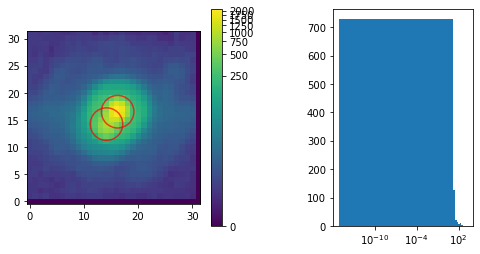

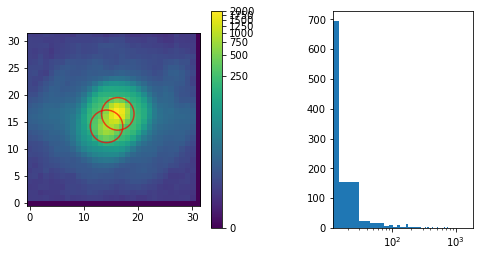

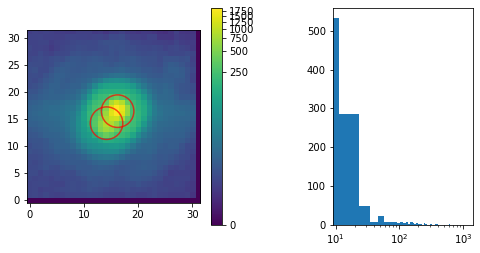

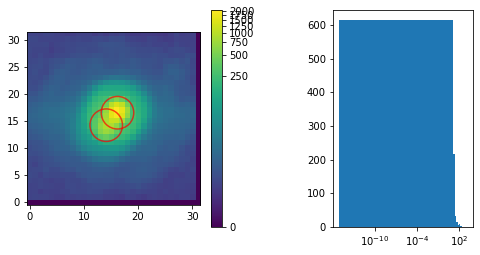

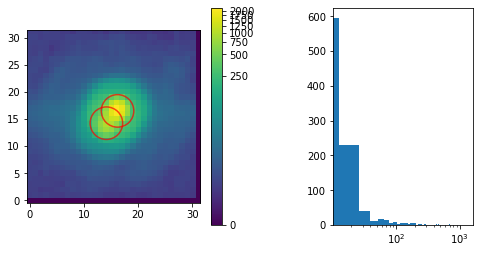

In [29]:
from astropy.io import fits
from photutils.centroids import centroid_sources
from photutils import CircularAperture
from astropy.stats import sigma_clip

for path in [darksubs[5]]:
    datadir = path.replace(path.split('\\')[-1], '')
    dataset = glob.glob(datadir+'*subdivtest*.fit*')
    for image in dataset:
        img = fits.getdata(image)
        xcens, ycens = centroid_sources(img, [13, 17], [13, 17], box_size=7)

        positions = np.transpose((xcens, ycens))
        apertures = CircularAperture(positions, r=3)

        fig = plt.figure(figsize=(8,4))
        ax1 = plt.subplot2grid((3,6), (0,0), rowspan=3, colspan=3)
        im_frame = ax1.imshow(img, norm=ImageNormalize(stretch=LogStretch()), origin='lower')
        apertures.plot(color='red', lw=1.5, alpha=0.7)
        plt.colorbar(im_frame, ax=ax1)
        ax2 = plt.subplot2grid((3,6), (0,4), rowspan=3, colspan=2)
        ax2.hist(sigma_clip(img.flatten(), sigma=10), bins=100)
        ax2.set_xscale('log')
        plt.show()

In [5]:
darksubs[27]

'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\\William\\trapezium_data\\visao_astro\\visao_20180426_27\\tet1OriB_HA_woll_005\\Theta1_Ori_B_2018-04-26_darksub_cube.fit'

In [6]:
import pandas as pd
data_frames = []
for path in [darksubs[27]]:
    datadir = path.replace(path.split('\\')[-1], '')
    dataset = glob.glob(datadir+'*subdivtest*.fit*')
    data = []
    dates = []
    filts = []
    for image in dataset:
        phot_results = VisAOLocate(image, 30, 5, 5, stampsize=75, epsfstamp=75, roundness=1,
                                  iterations=2, crit_sep=5, setfwhm=5, background_sloped=[5,5])
        data.append(phot_results)
        hdr = fits.getheader(image)
        date = hdr['DATE']
        if hdr['VFW1POS'] == 0.0:
                if hdr['VFW2POS'] == 0.0:
                    passband = hdr['VFW3POSN'].replace(' ','-')
                else:
                    passband = hdr['VFW2POSN'].replace('\'', 'prime')
        else:
            passband = hdr['VFW1POSN']
        dates.append(date)
        filts.append(passband)
    data2 = np.asarray(data)
    data_frame = pd.DataFrame(data=data2, columns=['sep','seperr','PA','PAerr'])
    data_frame['date'] = dates
    data_frame['filter'] = filts
    data_frames.append(data_frame)

ValueError: Empty data passed with indices specified.

In [10]:
data_frames

[         sep      seperr          PA       PAerr                 date  filter
 0  14.835103    0.105395  327.676341   -0.396223  2016-11-17T07:34:46  iprime
 1  12.648188  140.606405  279.312456 -173.940289  2016-11-17T07:34:46  iprime,
          sep    seperr          PA     PAerr                 date  filter
 0  14.924908  0.055627  326.752393 -0.277504  2016-11-17T07:31:55  zprime
 1  15.057733  0.064826  326.696620 -0.279162  2016-11-17T07:31:55  zprime]

In [15]:
data_frames[1].to_clipboard()

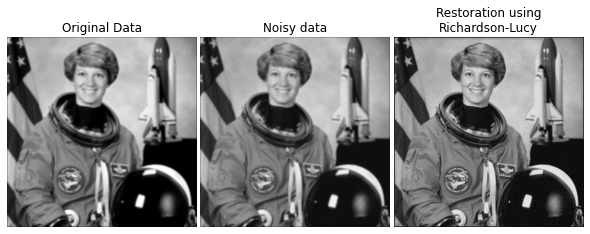

In [1]:
"""
=====================
Image Deconvolution
=====================
In this example, we deconvolve an image using Richardson-Lucy
deconvolution algorithm ([1]_, [2]_).
The algorithm is based on a PSF (Point Spread Function),
where PSF is described as the impulse response of the
optical system. The blurred image is sharpened through a number of
iterations, which needs to be hand-tuned.
.. [1] William Hadley Richardson, "Bayesian-Based Iterative
       Method of Image Restoration",
       J. Opt. Soc. Am. A 27, 1593-1607 (1972), :DOI:`10.1364/JOSA.62.000055`
.. [2] https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution
"""
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration

astro = color.rgb2gray(data.astronaut())

psf = np.ones((5, 5)) / 25
astro = conv2(astro, psf, 'same')
# Add Noise to Image
astro_noisy = astro.copy()
astro_noisy += (np.random.poisson(lam=25, size=astro.shape) - 10) / 255.

# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(astro_noisy, psf, iterations=30)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(astro)
ax[0].set_title('Original Data')

ax[1].imshow(astro_noisy)
ax[1].set_title('Noisy data')

ax[2].imshow(deconvolved_RL, vmin=astro_noisy.min(), vmax=astro_noisy.max())
ax[2].set_title('Restoration using\nRichardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()